# **Introduction**
The goal of this program is to detect deception in videos using the LSTM (Long Short Term Memory) network. We use LSTM because a single image or video frame is not enough to tell whether a person is lying. LSTM is well-suited for sequential analysis. The LSTM model will take Facial Landmarks (FLs) as an input and output a probability of the person telling the truth.<br><br>

Facial Landmarks (FLs) involves detecting and localizing specific points or landmarks on a face, such as the eyes, nose, mouth, and chin. We use Google MediaPipe to extract 478 landmarks, each with x and y coordinates. <br><br>


1.   For each video, we used MediaPipe to extract 478 FLs on each frame. The result for each video is saved as an npy file.
2.   We take the results of 30 consecutive video frames as 1 input (or chunk). For example, if a video has 240 frames, then it has 8 chunks.
3. We feed the chunks and the corresponding true/false value into an LSTM model




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import glob
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check for GPU availability and set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Mounted at /content/drive


# **Getting the Classified Output Y**

In [ ]:
EXCEL_DATA_PATH  = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package/MU3D Codebook.xlsx'
FOLDER = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package'
SAVE_NPY_PATH = FOLDER + "/" + "NPY_FILES(240frames)"

df = pd.read_excel(EXCEL_DATA_PATH, sheet_name="Video-Level Data")

# Iterate through each row of the Excel file
truthfulness = {}
for index, row in df.iterrows():
  truthfulness[row["VideoID"]] = row["Veracity"]

# 0 indicates lie, 1 indicates truth

# **Getting the Input X**
We have 320 video. Each video is represented by a (240, 478, 2) array. We will divide them into 8 chunks. So each chunk will be a (30, 956) array.

In [ ]:
# Takes a numpy array and convert it into chunks

def npy_to_npychunks(data):

  chunk_size = 30
  num_chunks = data.shape[0] // chunk_size

  # Split the array into chunks
  chunks = np.array_split(data[:num_chunks * 30], num_chunks)

  # Convert list of arrays to a single numpy array
  array = np.stack(chunks)
  return array

In [ ]:
import random

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)
  array = array.reshape(240, -1)
  print(array.shape)
  array = npy_to_npychunks(array)
  print(array.shape)
  num_chunks = array.shape[0]

  if output == 1:
    input_list_T.append(array)
    output_list_T += [output]*num_chunks
  else:
    input_list_F.append(array)
    output_list_F += [output]*num_chunks
  print(f"# of Videos Processed: {loop}")
  loop += 1


X_T = np.vstack(input_list_T)
X_F = np.vstack(input_list_F)
Y_T = np.array(output_list_T).reshape(-1,1)
Y_F = np.array(output_list_F).reshape(-1,1)



X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

(240, 956)
(8, 30, 956)
# of Videos Processed: 1
(240, 956)
(8, 30, 956)
# of Videos Processed: 2
(240, 956)
(8, 30, 956)
# of Videos Processed: 3
(240, 956)
(8, 30, 956)
# of Videos Processed: 4
(240, 956)
(8, 30, 956)
# of Videos Processed: 5
(240, 956)
(8, 30, 956)
# of Videos Processed: 6
(240, 956)
(8, 30, 956)
# of Videos Processed: 7
(240, 956)
(8, 30, 956)
# of Videos Processed: 8
(240, 956)
(8, 30, 956)
# of Videos Processed: 9
(240, 956)
(8, 30, 956)
# of Videos Processed: 10
(240, 956)
(8, 30, 956)
# of Videos Processed: 11
(240, 956)
(8, 30, 956)
# of Videos Processed: 12
(240, 956)
(8, 30, 956)
# of Videos Processed: 13
(240, 956)
(8, 30, 956)
# of Videos Processed: 14
(240, 956)
(8, 30, 956)
# of Videos Processed: 15
(240, 956)
(8, 30, 956)
# of Videos Processed: 16
(240, 956)
(8, 30, 956)
# of Videos Processed: 17
(240, 956)
(8, 30, 956)
# of Videos Processed: 18
(240, 956)
(8, 30, 956)
# of Videos Processed: 19
(240, 956)
(8, 30, 956)
# of Videos Processed: 20
(240, 956

# Data Split

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 2048
Testing Dataset Size: 512

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


# 2-Layer MLP

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_num, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_num, batch_first=True)
        self.dropout = nn.Dropout(0.20)
        self.linear = nn.Linear(200, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(self.dropout(out))
        out = self.sigmoid(out)
        return out



-------------------
Epoch 0: train loss 0.6950, test loss 0.6950, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 1: train loss 0.6933, test loss 0.6935, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 2: train loss 0.6930, test loss 0.6931, train accuracy 0.5078, test accuracy 0.5098
-------------------
Epoch 3: train loss 0.6934, test loss 0.6935, train accuracy 0.4995, test accuracy 0.5000
-------------------
Epoch 4: train loss 0.6929, test loss 0.6931, train accuracy 0.5068, test accuracy 0.5039
-------------------
Epoch 5: train loss 0.6934, test loss 0.6936, train accuracy 0.4990, test accuracy 0.5000
-------------------
Epoch 6: train loss 0.6936, test loss 0.6940, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 7: train loss 0.6930, test loss 0.6932, train accuracy 0.5054, test accuracy 0.5176
-------------------
Epoch 8: train loss 0.6930, test loss 0.6931, train accuracy 0.4985, test accuracy 0.4941
----------

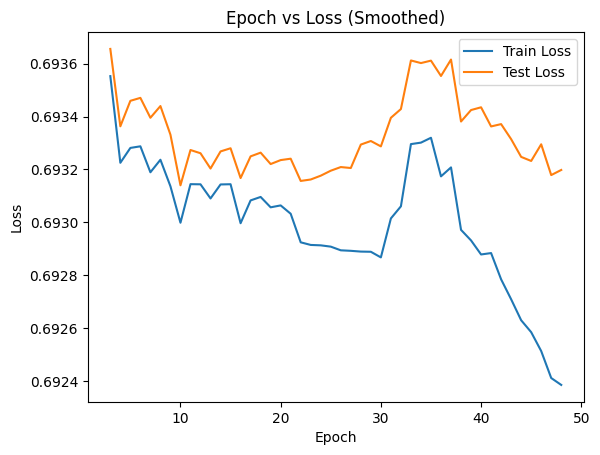

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Function to calculate accuracy
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


criterion = nn.BCELoss()
model = LSTMModel(input_dim=956, hidden_dim=200, layer_num=1, output_dim=1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        print("-------------------")
        # Calculate accuracy on training set
        y_pred = model(X_train_all)
        train_loss = criterion(y_pred, Y_train_all)
        train_acc = accuracy(y_pred, Y_train_all)

        # Calculate accuracy on test set
        y_pred = model(X_test_all)
        test_loss = criterion(y_pred, Y_test_all)

        test_acc = accuracy(y_pred, Y_test_all)

    print("Epoch %d: train loss %.4f, test loss %.4f, train accuracy %.4f, test accuracy %.4f" % (epoch, train_loss, test_loss, train_acc, test_acc))

    # Append the losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Smooth the losses using a moving average
window_size = 5
train_losses_smoothed = np.convolve(train_losses, np.ones(window_size) / window_size, mode='valid')
test_losses_smoothed = np.convolve(test_losses, np.ones(window_size) / window_size, mode='valid')

# Plotting epoch vs training loss and test loss
epochs = range(window_size // 2 + 1, num_epochs - window_size // 2 + 1)
plt.plot(epochs, train_losses_smoothed, label='Train Loss')
plt.plot(epochs, test_losses_smoothed, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Smoothed)')
plt.legend()
plt.show()

